<a href="https://colab.research.google.com/github/yoooobin/ESAA/blob/main/4_11_%EC%84%B8%EC%85%98_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EC%84%9D_%EC%97%B0%EC%8A%B5%EB%AC%B8%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **문서 유사도 분석**
* 각 단어를 축으로 하는 특성 공간(feature space)에서 문서들을 하나의 위치로 보고 특성 공간 상에서 거리를 이용해 두 문서의 유사성(similarity)을 측정하는 방식
    * 코사인 유사도(cosine similarity) : 두 벡터 간의 각도의 코사인 값을 이용하여 유사도를 계산, 크기가 아닌 방향성에 중점, 벡터의 길이(문서의 길이)에 영향을 받지 않음

In [1]:
!pip install koreanize-matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 29.2 MB/s eta 0:00:00


In [12]:
# 필요한 라이브러리를 import하세요.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## **1. 데이터 로드**

### 서울특별시 다산콜센터(☎120)의 주요 민원
* 서울특별시 다산콜센터(☎120)의 주요 민원(자주 묻는 질문)에 대한 답변정보
* https://opengov.seoul.go.kr/civilappeal/list

In [4]:
df = pd.read_csv("https://bit.ly/seoul-120-text-csv")
df.shape

(2645, 5)

In [5]:
df.head()

,번호,분류,제목,내용,내용번호
0,2645,복지,아빠 육아휴직 장려금,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경...,23522464
1,2644,경제,[서울산업진흥원] 서울메이드란?,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...,23194045
2,2643,환경,(강북구) 정비중,강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 높이고 폐기물을 감...,23032485
3,2642,복지,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)",광진맘택시 운영임산부영아 양육가정 전용 택시 업무개요 교통약자인 임산부와 영아가정...,22904492
4,2641,복지,마포 뇌병변장애인 비전센터,마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 구분 내용 목적 학...,22477798


In [8]:
# 중복데이터가 있는지 확인하세요.
sum(df.duplicated())

0

In [7]:
# 결측치를 확인하세요.
df.isnull().sum()

,0
번호,0
분류,0
제목,0
내용,0
내용번호,0


## **2. 벡터화**

* '제목' 열과 '내용' 열을 합친 '제목내용' 열을 만드세요.

In [10]:
df['제목내용'] = df['제목'] + df['내용']

In [11]:
df.head()

,번호,분류,제목,내용,내용번호,제목내용
0,2645,복지,아빠 육아휴직 장려금,아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려하고 양육에 따른 경...,23522464,아빠 육아휴직 장려금아빠 육아휴직 장려금 업무개요 남성근로자의 육아휴직을 장려...
1,2644,경제,[서울산업진흥원] 서울메이드란?,서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하고 새로운 경험을 제공하기 위해...,23194045,[서울산업진흥원] 서울메이드란?서울산업진흥원 서울메이드란 서울의 감성을 담은 다양하...
2,2643,환경,(강북구) 정비중,강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 높이고 폐기물을 감...,23032485,(강북구) 정비중강북구 정비중 업무개요 투명 폐트병을 교환보상하므로 수거율을 높...
3,2642,복지,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)",광진맘택시 운영임산부영아 양육가정 전용 택시 업무개요 교통약자인 임산부와 영아가정...,22904492,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)광진맘택시 운영임산부영아 양육가정 ..."
4,2641,복지,마포 뇌병변장애인 비전센터,마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 구분 내용 목적 학...,22477798,마포 뇌병변장애인 비전센터마포 뇌병변장애인 비전센터 마포뇌병변장애인 비전센터 운영 ...


* TfidfVectorizer를 이용하여 '제목내용' 열을 피처 벡터화하세요.
  * `tfidf`라는 이름으로 인스턴스를 생성하세요.
  * 'max_features=2000'으로 설정하세요.
  * 변환된 문서 용어 matrix는 `dtm`이라는 변수명으로 저장해주세요.

In [19]:
# '제목내용' 열 피처 벡터화 변환
tfidfvect = TfidfVectorizer(max_features=2000)
dtm = tfidfvect.fit_transform(df['제목내용'])

### 참고: fit, transform, fit_transfrom의 차이점
- fit(): 원시 문서에 있는 모든 토큰의 어휘 사전을 배운다.
- transform(): 문서를 문서 용어 매트릭스로 변환한다. transform 이후엔 매트릭스로 변환되어 숫자형태로 변경된다.
- fit_transform(): 어휘 사전을 배우고 문서 용어 매트릭스를 반환한다. fit 다음에 변환이 오는 것과 동일하지만 더 효율적으로 구현된다.

* API Document: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer.fit_transform

In [20]:
# 문장에서 노출되는 feature(특징이 될만한 단어) 수를 합한 변수 Document Term Matrix(이하 dtm)를 생성합니다.
# 아래 코드를 실행해주세요.
df_dtm_tfidf = pd.DataFrame(dtm.toarray(), columns=tfidfvect.get_feature_names_out())
df_dtm_tfidf.head()

,amp,apos,가격,가구,가구의,가급적,가까운,가꾸기,가능,가능하나,...,회의실,횡단보도,효율적으로,후에,후원,훈련,휴관,휴관일,휴무,희망하는
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.056218,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.113171,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: >

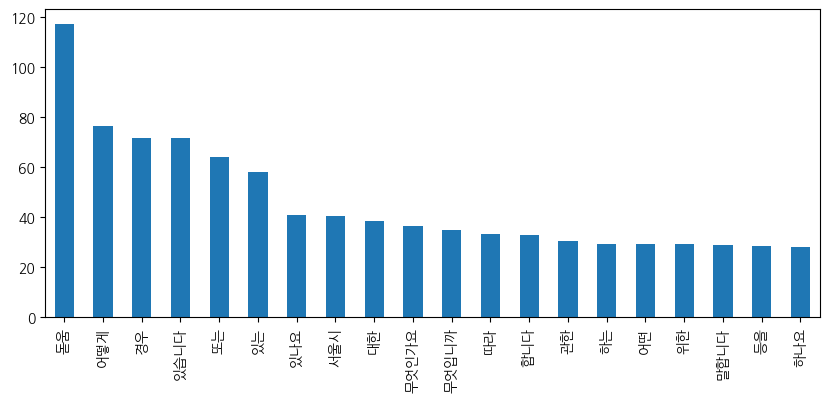

In [21]:
# 각 row에서 전체 단어가방에 있는 어휘에서 등장하는 단어에 대한 가중치를 적용한 vector를 확인합니다.
# 아래 셀을 실행해주세요.
df_dtm_tfidf.sum().nlargest(20).plot(kind="bar", figsize=(10, 4))

## 코사인 유사도


<img src="https://i.imgur.com/RdPPH33.png">
* 이미지 출처 : https://pyimagesearch.com/

<img src="https://storage.googleapis.com/lds-media/images/cosine-similarity-vectors.original.jpg">
* 이미지 출처 : https://www.learndatasci.com/glossary/cosine-similarity/




- 내적 공간 내에서 두 벡터 사이의 코사인 각도를 구하는 방법( –1∼1 사이 값을 가지며, 1에 가까울수록 유사도가 높다.)
- 벡터의 크기가 아닌 방향의 유사도를 판단하는 목적으로 사용되며, 두 벡터의 방향이 완전히 같을 경우 1, 90°의 각을 이룰 경우 0, 180°로 완전히 반대 방향인 경우 -1의 값을 갖음 >> 코사인 유사도에서는 각 데이터 간의 각도가 작을 수록 데이터가 비슷하다.
- 장점: 어떤 개수의 차원에도 적용할 수 있지만 흔히 다차원의 양수 공간에서의 유사도 측정에서 자주 이용한다.
- 단점: 상호 상관관계를 가지는 특성(키, 몸무게 등)를 갖는 원소들간의 유사도를 계산할때에 성능이 낮다.


* 코사인 유사도는 원점(모든 단어의 빈도가 0인 경우)에서 보았을 때 두 문서의 각도에 바탕을 둔 거리 측정 방식이다.
* 내적공간의 두 벡터간 각도의 코사인값을 이용하여 측정된 벡터간의 유사한 정도를 의미한다. 각도가 0°일 때의 코사인값은 1이며, 다른 모든 각도의 코사인값은 1보다 작다. 따라서 이 값은 벡터의 크기가 아닌 방향의 유사도를 판단하는 목적으로 사용되며, 두 벡터의 방향이 완전히 같을 경우 1, 90°의 각을 이룰 경우 0, 180°로 완전히 반대 방향인 경우 -1의 값을 갖는다. 이 때 벡터의 크기는 값에 아무런 영향을 미치지 않는다. 코사인 유사도는 특히 결과값이 [0,1]의 범위로 떨어지는 양수 공간에서 사용된다.
* 코사인 유사도는 어떤 개수의 차원에도 적용이 가능하여 흔히 다차원의 양수 공간에서의 유사도 측정에 자주 이용된다. 예를 들어 정보 검색 및 텍스트 마이닝 분야에서, 단어 하나 하나는 각각의 차원을 구성하고 문서는 각 단어가 문서에 나타나는 회수로 표현되는 벡터값을 가진다. 이러한 다차원 공간에서 코사인 유사도는 두 문서의 유사를 측정하는 매우 유용한 방법이다.
* 코사인 유사도는 데이터 마이닝 분야에서 클러스터들간의 응집도를 측정하는 방법으로도 사용된다.

* 출처: https://ko.wikipedia.org/wiki/%EC%BD%94%EC%82%AC%EC%9D%B8_%EC%9C%A0%EC%82%AC%EB%8F%84
* API Document: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html



$$ \text{{Cosine Similarity}}(A, B) = \frac{{A \cdot B}}{{\|A\|\|B\|}} = \frac{{\sum^n_{i=1}A_iB_i}}{{\sqrt{\sum^n_{i=1}A_i^2}\sqrt{\sum^n_{i=1}B_i^2}}} $$


https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html#sklearn-metrics-pairwise-cosine-similarity

* `sklearn.metrics.pairwise`에서 `cosine_similarity`를 불러온 후 코사인 유사도를 `ndarray` 형태로 반환하세요.
  * 생성된 코사인 유사도 행렬을 `cosine_matrix`라는 변수명으로 저장해주세요.

In [23]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_matrix = cosine_similarity(df_dtm_tfidf, df_dtm_tfidf)
cosine_matrix

array([[1.        , 0.        , 0.03938162, ..., 0.01994409, 0.        ,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03938162, 0.        , 1.        , ..., 0.02733107, 0.        ,
        0.        ],
       ...,
       [0.01994409, 0.        , 0.02733107, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        0.32093317],
       [0.        , 0.        , 0.        , ..., 0.        , 0.32093317,
        1.        ]])

<Axes: >

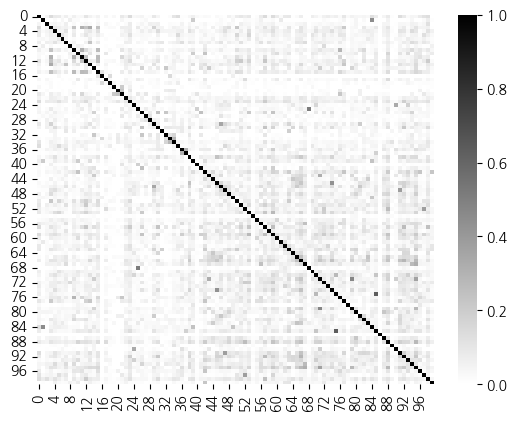

In [24]:
# 코사인 유사도를 시각화합니다.
# 아래 셀을 실행해주세요.
sns.heatmap(cosine_matrix[:100, :100], cmap="gray_r")

## 유사도가 높은 문서

* 첫 번째 행에 대한 코사인 유사도를 'similarity_0'이라는 파생변수로 생성하고 유사도가 높은 순으로 정렬합니다.
  * '번호', '제목', 'similarity_0' 열이 모두 나오게 출력하세요.
  * 제안 : `nlargest(n, columns)` 메소드를 써도 좋습니다.

In [29]:
df['similarity_0'] = cosine_matrix[0, ]
df[['번호', '제목', 'similarity_0']].nlargest(20, 'similarity_0')

,번호,제목,similarity_0
0,2645,아빠 육아휴직 장려금,1.000000
1772,873,도시계획시설부지 재결신청 이후 진행단계는 어떤 과정을 거칩니까?,0.213203
1073,1572,부기등기 이후 제한물권 설정의 효력은?,0.182378
155,2490,[농업기술센터] 후계농업경영인 선정 및 청년창업형 후계농업경영인 신청 안내,0.179294
539,2106,행려자도 아니고 시설수용자도 아닌 사람이 살고 있던 비닐하우스에서 화상을 입었습니다...,0.168208
2252,393,내가 가입되어 있는 보험이 무엇이 있는지 조회할수 있나요?,0.163740
2222,423,장애인을 위한 방송수신기 보급사업,0.161021
2095,550,서울수화전문교육원,0.152475
141,2504,[농업기술센터] 도시농업전문가양성교육 신청,0.152014
2444,201,중소기업 협동조합 설립신청,0.151583


## 유사도가 낮은 문서

* 위와 같은 방법으로 유사도가 낮은 순으로 정렬합니다.
  * 제안 : `nsmallest(n, columns)` 메소드를 써도 좋습니다.

In [30]:
df[['번호', '제목', 'similarity_0']].nsmallest(100, 'similarity_0')

,번호,제목,similarity_0
1,2644,[서울산업진흥원] 서울메이드란?,0.0
16,2629,등록된 법인의 지점이나 사업소는 별도로 등록해야 시공이 가능한가요 ?,0.0
20,2625,ESCO사업의 주요 사업분야에는 어떤게 있나요?,0.0
31,2614,3.1절 나라사랑 기념행사,0.0
32,2613,궁동체육관 FAQ,0.0
...,...,...,...
397,2248,서울의 호칭(명칭)은 언제부터 생겼나요?,0.0
398,2247,"주요 손해보험사 (사고보상, 긴급출동서비스), 생명보험사 연락처",0.0
403,2242,민원을 내기 전에 유사사례를 검색할 수 있을까요?,0.0
404,2241,은평구 관내 볼링장 이용안내,0.0


### 유사도가 높은 문서 찾는 함수 만들기
* chatGPT, 구글링을 이용하여 하나의 행에 대해 유사도가 높은 문서 순으로 정렬하는 함수를 만들어보세요.

In [37]:
def similarity_highest(df, textcol=0, ncol=0, nprint=20):
    tfidf = TfidfVectorizer()
    dtm = tfidf.fit_transform(df[textcol])
    cosine_matrix = cosine_similarity(dtm, dtm)
    df[f'similarity{ncol}'] = cosine_matrix[ncol]
    return df.nlargest(nprint, f'similarity{ncol}')

In [38]:
# 변수를 넣어 점검해보세요.
similarity_highest(df, textcol='제목내용', ncol=3)

,번호,분류,제목,내용,내용번호,제목내용,similaruity_0,similaraity_0,similarity_0,similarity3
3,2642,복지,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)",광진맘택시 운영임산부영아 양육가정 전용 택시 업무개요 교통약자인 임산부와 영아가정...,22904492,"광진맘택시 운영(임산부,영아 양육가정 전용 택시)광진맘택시 운영임산부영아 양육가정 ...",0.141904,0.141904,0.141904,1.000000
342,2303,교통,택시 내 지정부착물 이란?,택시 내 지정부착물 이란 개요 지정부착물이란 시에서 ...,2898286,택시 내 지정부착물 이란?택시 내 지정부착물 이란 개요 ...,0.027370,0.027370,0.027370,0.115581
2088,557,교통,공항내 택시 불법영업 신고,공항내 택시 불법영업 신고 공항내 택시 불법영업 신고 김포공항 김포...,2898362,공항내 택시 불법영업 신고공항내 택시 불법영업 신고 공항내 택시 불법영업 ...,0.013982,0.013982,0.013982,0.099330
143,2502,문화관광,장구 강습,장구 강습삼청동 자치회관 장구반 강좌 대상 종로구민 인원 명 이내선착순 모집 장소 ...,2897289,장구 강습장구 강습삼청동 자치회관 장구반 강좌 대상 종로구민 인원 명 이내선착순 모...,0.052153,0.052153,0.052153,0.096827
9,2636,교통,반반택시 (심야시간 택시 동승앱),반반택시 심야시간 택시 동승앱 업무개요 심야 택시수요 대비 택시공급 부족으로 발...,18409818,반반택시 (심야시간 택시 동승앱)반반택시 심야시간 택시 동승앱 업무개요 심야 택...,0.060551,0.060551,0.060551,0.092949
12,2633,복지,장기요양 이동지원서비스(모두타 돌봄택시),장기요양 이동지원서비스모두타 돌봄택시 업무개요 보건복지부와 서울시택시운송사업조...,17896364,장기요양 이동지원서비스(모두타 돌봄택시)장기요양 이동지원서비스모두타 돌봄택시 업...,0.104210,0.104210,0.104210,0.091539
13,2632,경제,취약가구 반려동물 동물등록.중성화 지원,취약가구 반려동물 동물등록중성화 지원구분 내용 업무개요 서울시 동물돌봄의료서비스는 ...,17837688,취약가구 반려동물 동물등록.중성화 지원취약가구 반려동물 동물등록중성화 지원구분 내용...,0.054036,0.054036,0.054036,0.090726
11,2634,교통,"[종료사업] S-Taxi 앱 (에스택시, 서울택시승차앱) 시범운영",종료사업 앱 에스택시 서울택시승차앱 시범운영업무개요 빈차를 보고 택시를 이용 하는 ...,17949033,"[종료사업] S-Taxi 앱 (에스택시, 서울택시승차앱) 시범운영종료사업 앱 에스택...",0.028200,0.028200,0.028200,0.090711
2267,378,복지,[육아종합지원센터(구.보육정보센터)] 이용안내,육아종합지원센터구보육정보센터 이용안내 ...,19004079,[육아종합지원센터(구.보육정보센터)] 이용안내육아종합지원센터구보육정보센터 이용안내 ...,0.134747,0.134747,0.134747,0.083921
2177,468,교통,택시요금을 현금으로 결제시 현금영수증 어떻게 발급 받나요?,택시요금을 현금으로 결제시 현금영수증 어떻게 발급 받나요 업무개요 택...,2898374,택시요금을 현금으로 결제시 현금영수증 어떻게 발급 받나요?택시요금을 현금으로 결제시...,0.020624,0.020624,0.020624,0.083090
